In [1]:
 using Plots

The function accel() adds up all forces and returns the acceleration
There is a small inperfection in how the frictional force ffri is treated:
- initially when the mass is at rest, sign(v)=0 and there will be no friction
- at the fillowing step, the mass has velocity > 0, and ffri < 0
- the small v > 0 of the first step will the v rapidly decrease
- in some cases, a small negative velocity may result from the discretization
- but then the frictional force will be > 0 and again act to impede the motion
The result of the imperfection is that the mass initially, when it should
really stay at rest, has some very low, in some case oscillating, velocity
The behavior is "self correcting", diminishing when dt is decreased
- because of the self-correction there is no need to treat v=0 as a special case

The spring has native (relaxed) length lspr and can be elongated without bounds
and compressed to length 0. The final compression force is divergent to avoid the
spring length becoming negative (in principle a max length should also be imposed)
The friction force if fr0 at rest, decays rapidly to fr1 as v increases

In [2]:
 function accel(x,v,t,mass,kspr,lspr,xspr,kwall,fr0,fr1)
    fspr=(xspr-x-lspr)*kspr-kwall/abs(xspr-x)^6      # force from spring
    ffri=fr1+(fr0-fr1)*exp(-abs(v)*1)              # friction force magnitude
    ffri=-ffri*sign(v)                               # sign of friction depends on velocity
    return (fspr+ffri)/mass
 end


accel (generic function with 1 method)


The function integrate1() carries out nt spes of the standard leapfrog algorithm
Results are written to the file "x.dat" evert wt steps and also pushed to vectors
The step error is not very good with the leapfrog method in the presence of friction
(good results can still be obtained quickly with reasonable dt values)


In [3]:
function integrate1(dt,wt,nt,mass,kspr,lspr,vspr,kwall,fr0,fr1)
    v=0.
    x=0.
    fi=open("x.dat","w")
    vect=Vector{Float64}()
    vecx=Vector{Float64}()
    vecv=Vector{Float64}()
    vecl=Vector{Float64}()
    for i=0:nt
        t=i*dt        
        xspr=lspr+t*vspr 
        if mod(i,wt)==0
           println(fi,t,"  ",x,"  ",xspr-x,"  ",v)           
           push!(vect,t)
           push!(vecx,x)
           push!(vecv,v)
           push!(vecl,xspr-x)
        end
        v=v+dt*accel(x,v,t,mass,kspr,lspr,xspr,kwall,fr0,fr1)
        x=x+dt*v        
    end
    close(fi)
    return vect,vecx,vecv,vecl
 end


integrate1 (generic function with 1 method)

The function integrate2() carries out nt steps of the leapfrog algorithm with
correction steps to better treat the damping. Otherwise same as integrate1()

In [4]:
 function integrate2(dt,wt,nt,mass,kspr,lspr,vspr,kwall,fr0,fr1)
    v=0.
    x=0.
    x1=0.
    fi=open("x.dat","w")
    vect=Vector{Float64}()
    vecx=Vector{Float64}()
    vecv=Vector{Float64}()
    vecl=Vector{Float64}()
    for i=0:nt
        t=i*dt        
        xspr=lspr+t*vspr 
        if mod(i,wt)==0
           println(fi,t,"  ",x,"  ",xspr-x,"  ",v)           
           push!(vect,t)
           push!(vecx,x)
           push!(vecv,v)
           push!(vecl,xspr-x)
        end
        u=v+0.5*dt*accel(x,v,t,mass,kspr,lspr,xspr,kwall,fr0,fr1)
        y=x+dt*u         # intermediate position
        u=0.5*(y-x1)/dt  # intermediate velocity, x1 is x_{n-1}
        v=v+dt*accel(x,u,t,mass,kspr,lspr,xspr,kwall,fr0,fr1)
        x1=x             # saving what will be x_{n-1} in the next step
        x=x+dt*v                
    end
    close(fi)
    return vect,vecx,vecv,vecl
 end


integrate2 (generic function with 1 method)

In [12]:
# Setting parameters related to the leapfrog loop
dt=0.01        # time step
wt=10         # write to file every wt step
nt=5000       # number of time steps

# Setting parameters related to the system 
# - mass connected to spring, the end of which is connected to a moving wall

mass=1.          # block mass
kspr=1.          # spring constant
lspr=1.          # native spring length
vspr=0.1         # constant velocity of spring end (wall); a kind of driving
kwall=0.0001     # constant in repulsive spring compression force
fr0=1.           # friction force at rest
fr1=0.5;          # friction force while in motion

Doing the integration for time step dt and then the same for dt/10,
plotting t,x,v, or l (the latter being the spring length) after each time.


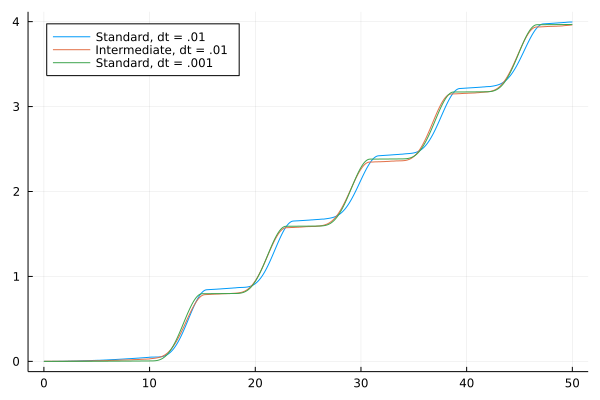

In [13]:
t,x,v,l=integrate1(dt,wt,nt,mass,kspr,lspr,vspr,kwall,fr0,fr1)

plot(t,x, label = "Standard, dt = .01")

t,x,v,l=integrate2(dt,wt,nt,mass,kspr,lspr,vspr,kwall,fr0,fr1)

plot!(t,x, label = "Intermediate, dt = .01")

dt=dt/10
wt=wt*10
nt=nt*10

t,x,v,l=integrate1(dt,wt,nt,mass,kspr,lspr,vspr,kwall,fr0,fr1)

plot!(t,x, label = "Standard, dt = .001", legend=:topleft)



┌ Info: Saved animation to 
│   fn = /Users/gabeschumm/BU/22fa/PY502/code/tmp.gif
└ @ Plots /Users/gabeschumm/.julia/packages/Plots/PomtQ/src/animation.jl:114


Plots.AnimatedGif("/Users/gabeschumm/BU/22fa/PY502/code/tmp.gif")
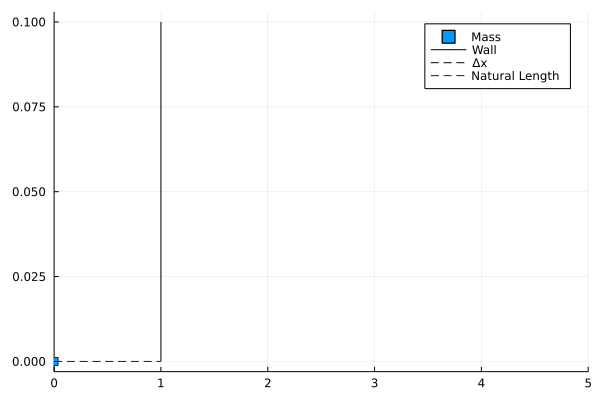

In [22]:
@gif for i in 1:Int64(nt/wt)
    scatter([x[i]], [0], xlim = (0, 5), label="Mass", markershape=:rect)
    plot!([lspr+(t[i]*vspr) , lspr+(t[i]*vspr) ], [0, .1], label="Wall", c=:black)
    plot!([x[i] , (t[i]*vspr) ], [0, 0], label="Δx", c=:black, linestyle=:dash)
    plot!([(t[i]*vspr) , lspr+(t[i]*vspr) ], [0, 0], label="Natural Length", c=:blue, linestyle=:dash)
    
    end